## keras构建回归模型(Wide & Deep subclass implementation)

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0-alpha0
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)
matplotlib 3.1.0
numpy 1.14.5
pandas 0.24.2
sklearn 0.21.2
tensorflow 2.0.0-alpha0
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
from sklearn.model_selection import train_test_split

# 默认划分比例为3:1
X_train_all, X_test, y_train_all, y_test = train_test_split(housing.data, housing.target,
                                                           random_state=7)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all,
                                                     random_state=11)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [5]:
# 多个输入，使用函数式API
# 模拟wide侧和deep侧的输入
input_wide = keras.layers.Input(shape=[5])
input_deep = keras.layers.Input(shape=[6])

hidden1 = keras.layers.Dense(30, activation='relu')(input_deep)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)

concat = keras.layers.concatenate([input_wide, hidden2])
output = keras.layers.Dense(1)(concat)

# 模型固化
model = keras.models.Model(inputs=[input_wide, input_deep],
                          outputs=[output])
model.compile(loss='mean_squared_error', optimizer='sgd')
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           210         input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
______________________________________________________________________________________________

In [6]:
# wide为前五个特征，deep侧为后六个特征，中间会有所重合
X_train_scaled_wide = X_train_scaled[:, :5]
X_train_scaled_deep = X_train_scaled[:, 2:]
X_valid_scaled_wide = X_valid_scaled[:, :5]
X_valid_scaled_deep = X_valid_scaled[:, 2:]
X_test_scaled_wide = X_test_scaled[:, :5]
X_test_scaled_deep = X_test_scaled[:, 2:]

log_his = model.fit([X_train_scaled_wide, X_train_scaled_deep], y_train,
                   validation_data=([X_valid_scaled_wide, X_valid_scaled_deep], y_valid),
                   epochs=100,
                   callbacks=callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 0s 41us/sample - loss: 2.3788 - val_loss: 1.1917
Epoch 2/100
11610/11610 [==============================] - 0s 29us/sample - loss: 0.9070 - val_loss: 0.8258
Epoch 3/100
11610/11610 [==============================] - 0s 29us/sample - loss: 0.7091 - val_loss: 0.7117
Epoch 4/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.6341 - val_loss: 0.6554
Epoch 5/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.5958 - val_loss: 0.6229
Epoch 6/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.5706 - val_loss: 0.6011
Epoch 7/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.5538 - val_loss: 0.5843
Epoch 8/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.5407 - val_loss: 0.5723
Epoch 9/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.529

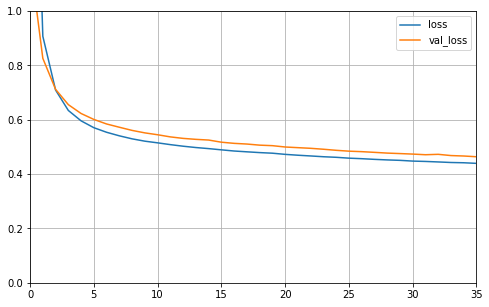

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(log_his)

In [8]:
model.evaluate([X_test_scaled_wide, X_test_scaled_deep], y_test)

5160/5160 [==============================] - 0s 12us/sample - loss: 0.4515


0.451535323516343